In [1]:
#importing required python classes and packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dtaidistance import dtw
from scipy import spatial
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint
import os
import pickle

Using TensorFlow backend.
c:\users\123\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\123\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\123\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
#loading and displaying VM performance dataset
refrence_dataset = pd.read_csv("Dataset/ResourceDataset.csv", sep=";")
refrence_dataset

,timestamp,cpu_usage_list,mem_usage_percent_list,disk_read_list,disk_write_list,net_in_list,net_out_list,resource_id
0,1.376319e+09,0.188889,2.475921,0.000000,0.346667,0.102222,0.073333,0
1,1.376328e+09,0.162222,2.576701,0.011111,0.306667,0.100000,0.068889,0
2,1.376337e+09,0.288889,3.300481,10.146667,5.444444,1.811111,36.557778,1
3,1.376346e+09,0.144444,2.975243,0.000000,0.348889,0.095556,0.068889,0
4,1.376355e+09,0.160000,3.133280,0.000000,3.948889,0.800000,0.113333,0
...,...,...,...,...,...,...,...,...
537,1.378094e+09,0.297302,20.385207,0.000000,1.191111,58.704603,59.558254,1
538,1.378103e+09,0.254444,20.977367,0.000000,1.123492,41.203333,41.928730,1
539,1.378112e+09,0.275556,20.139177,0.000000,1.102222,58.117778,59.173333,1
540,1.378121e+09,0.235556,20.658910,0.000000,1.100000,38.986667,39.715556,0


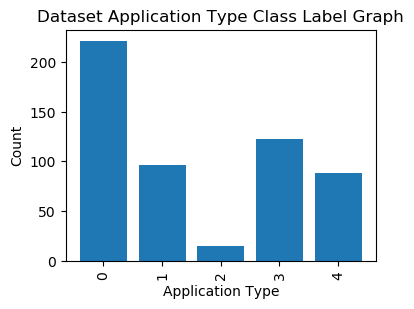

In [3]:
#plotting graph of different application types found in dataset
#visualizing class labels count found in dataset
names, count = np.unique(refrence_dataset['resource_id'], return_counts = True)
height = count
bars = names
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Application Type")
plt.title("Dataset Application Type Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [4]:
#executing existing LSTM algorithm on full dataset without using ANY DTW technique
Y = refrence_dataset.values[:,1:2]
refrence_dataset.drop(['cpu_usage_list', 'resource_id'], axis=1, inplace=True)
X = refrence_dataset.values
#code to normalize values
scaler = MinMaxScaler(feature_range = (0, 1))
scaler1 = MinMaxScaler(feature_range = (0, 1))
#normalizing training data
X = scaler.fit_transform(X)
Y = scaler1.fit_transform(Y)
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#defining and training LSTM algorithm using all features without uisng DTW
lstm_model = Sequential()#defining object
#adding lstm layer with 50 nuerons to filter dataset 50 time
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])))
#dropout layer to remove irrelevant features from dataset
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1))#defining output crop yield prediction layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
#now train and load the model
if os.path.exists("model/existing_lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/existing_lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train1, y_train, batch_size = 16, epochs = 30, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/existing_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_model.load_weights("model/existing_lstm_weights.hdf5")
predict = lstm_model.predict(X_test1)
existing_accuracy = 1 - mean_squared_error(y_test, predict)
print("Existing LSTM Accuracy Without DTW : "+str(existing_accuracy))


Existing LSTM Accuracy Without DTW : 0.9789851183030941


In [5]:
#defining function to identify application type using DTW and euclidean distance
def findApplicationType(X, Y, test_data):
    app_type = []
    for i in range(len(test_data)):
        distance = 100000
        types = "none"
        for j in range(len(X)):
            dist = spatial.distance.euclidean(X[j], test_data[i])#calculate distance between refrence and test data
            if dist < distance:#choose application type with minimum distance
                types = Y[j]
                distance = dist
        app_type.append(types)
    return np.asarray(app_type)   

c:\users\123\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\123\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


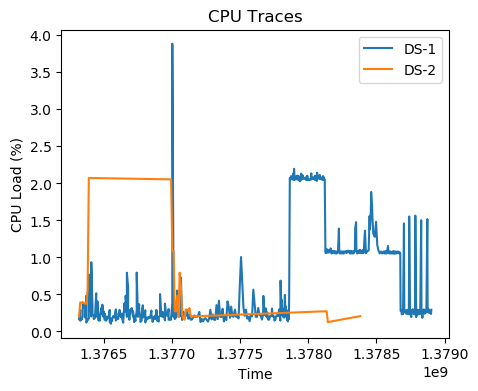

In [6]:
#plot normal CPU traces and can see there is lots of stretched in load while processing normal load so to have temporal 
#mismatch like lengthy stretched we will apply dynamic time wrapiong (DTW)
refrence_dataset = pd.read_csv("Dataset/ResourceDataset.csv", sep=";")
test_dataset = pd.read_csv("Dataset/testData.csv", sep=";")
plt.figure(figsize=(5,4))
plt.plot(refrence_dataset['timestamp'].sort_values(), refrence_dataset['cpu_usage_list'].ravel(), label='DS-1')
plt.plot(test_dataset['timestamp'].sort_values(), test_dataset['cpu_usage_list'].ravel(), label = 'DS-2')
plt.xlabel("Time")
plt.ylabel("CPU Load (%)")
plt.title("CPU Traces")
plt.legend()
plt.show()

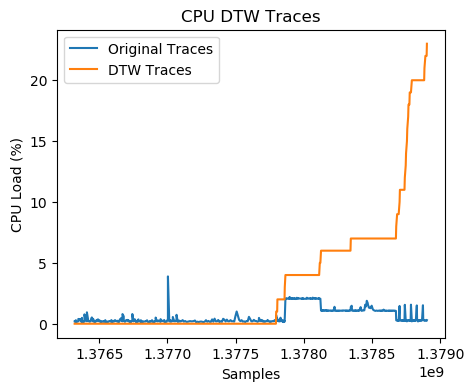

In [7]:

#calculate DTW values on loaded data
dtw_values = dtw.warping_path(refrence_dataset['cpu_usage_list'].ravel(), test_dataset['cpu_usage_list'].ravel())
dtw_values = np.asarray(dtw_values)
plt.figure(figsize=(5,4))
plt.plot(refrence_dataset['timestamp'].sort_values(), refrence_dataset['cpu_usage_list'].ravel(), label='Original Traces')
plt.plot(refrence_dataset['timestamp'].sort_values(), dtw_values[:,1][0:542], label = 'DTW Traces')
plt.xlabel("Samples")
plt.ylabel("CPU Load (%)")
plt.title("CPU DTW Traces")
plt.legend()
plt.show()

In [8]:
#identifying applictaion type for test data using refrence data
refrence = refrence_dataset.values
test = test_dataset.values
XX = refrence[:,0:refrence.shape[1]-1]
YY = refrence[:,refrence.shape[1]-1]
#finding app type for test data
app_type = findApplicationType(XX, YY, test)
print("App Type for test data : "+str(app_type))

App Type for test data : [0. 1. 1. 2. 4. 4. 3. 3. 1. 1. 1. 0. 2. 2. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0.]


In [9]:
#applying pearson formula to get highly corelated variables
refrence_dataset.drop(['resource_id'], axis=1, inplace=True)
columns = refrence_dataset.columns.tolist()
corr = refrence_dataset.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=0.5).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] < 0.016)]#selecting highly correlated metrics
refrence_dataset.drop(to_drop, axis=1, inplace=True)
Y = refrence_dataset.values[:,1:2]
refrence_dataset.drop(['cpu_usage_list'], axis=1, inplace=True)
X = refrence_dataset.values
selected_columns = []
for i in range(len(columns)):
    if columns[i] not in to_drop:
        selected_columns.append(columns[i])
print("Total columns found in Dataset : "+str(columns))
print()
print("Total columns after selecting highly correlated features : "+str(selected_columns))

Total columns found in Dataset : ['timestamp', 'cpu_usage_list', 'mem_usage_percent_list', ' disk_read_list', 'disk_write_list', 'net_in_list', 'net_out_list']

Total columns after selecting highly correlated features : ['timestamp', 'cpu_usage_list', 'mem_usage_percent_list', 'disk_write_list', 'net_in_list']


In [10]:
#now train propose LSTM algorithm using DTW & high correlated Metrics
scaler = MinMaxScaler(feature_range = (0, 1))
scaler1 = MinMaxScaler(feature_range = (0, 1))

X = scaler.fit_transform(X)
Y = scaler1.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#train propose LSTM algorithm with highly selected metrics and DTW values
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()#defining object
#adding lstm layer with 50 nuerons to filter dataset 50 time
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])))
#dropout layer to remove irrelevant features from dataset
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1))#defining output crop yield prediction layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
#now train and load the model
if os.path.exists("model/propose_lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/propose_lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train1, y_train, batch_size = 16, epochs = 30, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/propose_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_model.load_weights("model/propose_lstm_weights.hdf5")
#perform performance prediction using propose LSTM algorithm and then calculare accuracy    
predict = lstm_model.predict(X_test1)
propose_accuracy = 1 - mean_squared_error(y_test, predict)
print("Propose LSTM Accuracy With DTW : "+str(propose_accuracy))

Propose LSTM Accuracy With DTW : 0.988985354645062


In [11]:
#train extension GRU algorithm
gru_model = Sequential()#defining object
#adding GRU layer with 50 nuerons to filter dataset 50 time
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])))
#dropout layer to remove irrelevant features from dataset
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(units=1))#defining output crop yield prediction layer
gru_model.compile(optimizer='adam', loss='mean_squared_error')
#now train and load the model
if os.path.exists("model/extension_gru_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_gru_weights.hdf5', verbose = 1, save_best_only = True)
    hist = gru_model.fit(X_train1, y_train, batch_size = 16, epochs = 30, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    gru_model.load_weights("model/extension_gru_weights.hdf5")
#perform performance prediction using extension GRU algorithm and then calculare accuracy       
predict = gru_model.predict(X_test1)
extension_accuracy = 1 - mean_squared_error(y_test, predict)
print("Extension GRU Accuracy With DTW : "+str(extension_accuracy))

Extension GRU Accuracy With DTW : 0.9884696538685936


In [12]:
#display all algorithm performnace in table format
data = []
data.append(["Existing LSTM without DTW", existing_accuracy])
data.append(["Propose LSTM with DTW", propose_accuracy])
data.append(["Extension GRU with DTW", extension_accuracy])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy'])
data  

,Algorithm Name,Accuracy
0,Existing LSTM without DTW,0.978985
1,Propose LSTM with DTW,0.988985
2,Extension GRU with DTW,0.988470


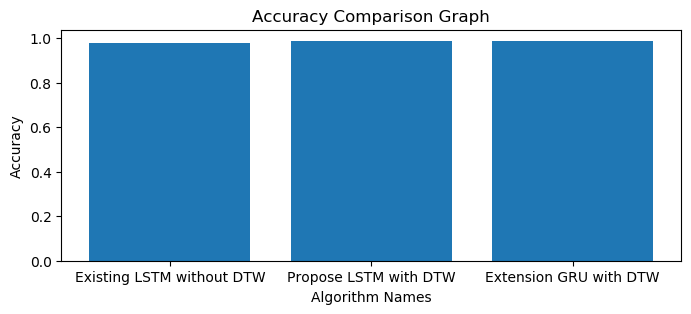

In [13]:
#plot all algorithm performance in graph format
height = [existing_accuracy, propose_accuracy, extension_accuracy]
bars = ["Existing LSTM without DTW", "Propose LSTM with DTW", "Extension GRU with DTW"]
y_pos = np.arange(len(height))
plt.figure(figsize = (8, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Algorithm Names")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Graph")
plt.show()

In [14]:
#function to read training error values
def values(filename, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    loss_value = train_values[loss]
    return loss_value   

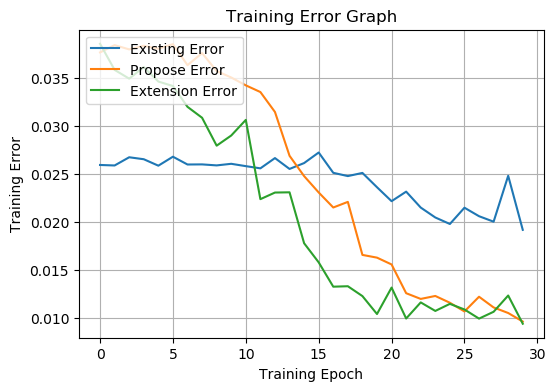

In [15]:
#plot training errror graph
existing_error = values("model/existing_history.pckl", "val_loss")
propose_error = values("model/propose_history.pckl", "val_loss")
extension_error = values("model/extension_history.pckl", "val_loss")
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Training Epoch')
plt.ylabel('Training Error')
plt.plot(existing_error)
plt.plot(propose_error)
plt.plot(extension_error)
plt.legend(['Existing Error', 'Propose Error','Extension Error'], loc='upper left')
plt.title('Training Error Graph')
plt.show()

In [16]:
#calculate base line performance using neural network algorithm
#loading test data
testData = pd.read_csv("Dataset/testData.csv", sep=";")
data = testData
#identifying application type using euclidean and DTW algorithm on reference data and test data
app_type = findApplicationType(XX, YY, testData.values)
#droping all least correlated metrics and keeping only highly corelated metrics 
testData.drop(to_drop, axis=1, inplace=True)
testData.drop(['cpu_usage_list'], axis=1, inplace=True)
testData = testData.values
#normalizing test data
testData = scaler.transform(testData)
testData = np.reshape(testData, (testData.shape[0], testData.shape[1], 1))
#using extension GRU model predicting Cloud performance
predict = gru_model.predict(testData)
predict = predict.reshape(-1, 1)
predict = scaler1.inverse_transform(predict)
predict = predict.ravel()
data['Application_id'] = app_type
data = data.values
#if predicted work load on highly correlated metrics > 70 or 100% then extra processor required
#which indicates performance will be degrade otherwise best base line performance will be achieved
for i in range(len(data)):
    if predict[i] > 0.70:
        output = "Performance Degradation Detected"
    else:
        output = "Best Performance Detected"
    print("Test VM Data = "+str(data[i])+" Predicted Performance ===> "+output+"\nIdentified Application Type = "+str(app_type[i])+"\n")    

Test VM Data = [1.37637320e+09 2.55608657e+00 3.37777778e-01 9.77777778e-02
 0.00000000e+00] Predicted Performance ===> Best Performance Detected
Identified Application Type = 0.0

Test VM Data = [1.37638220e+09 2.86530001e+00 4.06666667e-01 1.80000000e+00
 1.00000000e+00] Predicted Performance ===> Best Performance Detected
Identified Application Type = 1.0

Test VM Data = [1.37639120e+09 3.52724021e+00 1.38000000e+00 1.82222222e-01
 1.00000000e+00] Predicted Performance ===> Best Performance Detected
Identified Application Type = 1.0

Test VM Data = [1.37838040e+09 3.59595334e+00 1.23111111e+00 1.84444444e-01
 2.00000000e+00] Predicted Performance ===> Best Performance Detected
Identified Application Type = 2.0

Test VM Data = [1.37631920e+09 1.34740610e+01 3.34666667e+00 0.00000000e+00
 4.00000000e+00] Predicted Performance ===> Performance Degradation Detected
Identified Application Type = 4.0

Test VM Data = [1.37632820e+09 1.31149173e+01 3.21301587e+00 2.22222222e-03
 4.00000000e